## Imports

In [1]:
import sys
import os

# Get the current working directory (where the notebook is located)
current_dir = os.getcwd()

# Add the parent directory to sys.path
sys.path.append('../models')
sys.path.append('../scripts')

In [2]:
import torch
import torch.nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
import torch.nn.functional as F
import os
from random import randint
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from autoencoder import ResNetAutoencoder
from mtg_cards_dataset import MTGCardsDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

BATCH_SIZE = 20
NUM_EPOCHS = 1
LOGGING_INTERVAL = 150
SAVE_MODEL = True
LOAD_MODEL = True

# Displaying Dataset

## Preview Dataset

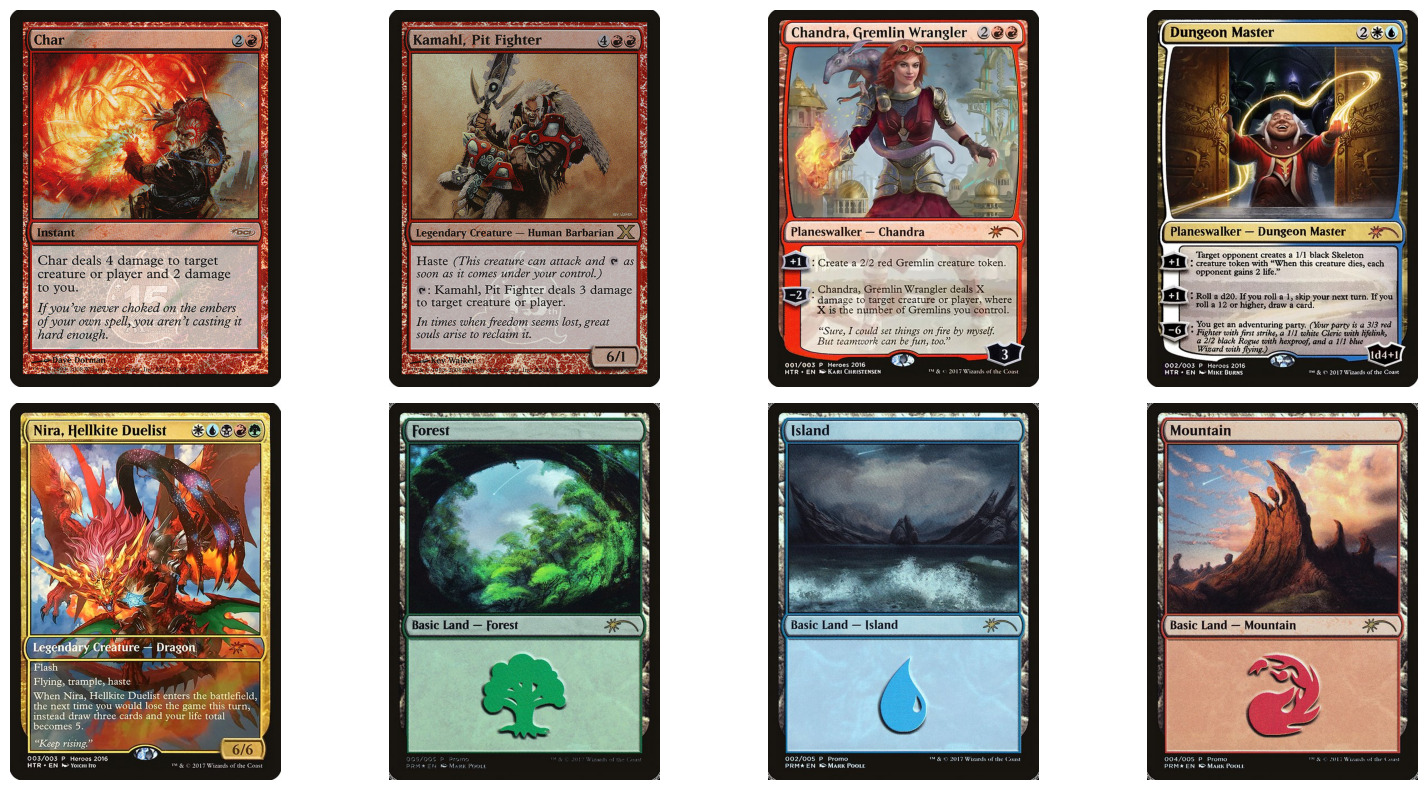

In [3]:
def show_images(dataset, num_samples=10, cols=4):
    """Plots some samples from the dataset."""
    transform_to_pil = transforms.ToPILImage()
    rows = (num_samples + cols - 1) // cols  # Calculate rows needed
    plt.figure(figsize=(cols * 4, rows * 4))  # Adjust figure size
    
    for i in range(num_samples):
        img, _ = dataset[i]  # Extract image and label (label is ignored here)
        img = transform_to_pil(img)  # Convert tensor to PIL image for plotting
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide axes for cleaner visualization
    
    plt.tight_layout()  # Optimize spacing between images
    plt.show()

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

transform = transforms.Compose([
    transforms.ToTensor()          # Convert images to tensors
])

data_dir = "../data"
preview_dataset = MTGCardsDataset(data_dir, transform=transform)

show_images(preview_dataset, num_samples=8)

# Training

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
])

dataset = MTGCardsDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1)

C:\Users\agill\AppData\Local\Temp\ipykernel_23336\3380235962.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_models/autoencoder

Epoch 1, Batch 1, Loss: 0.06110868975520134


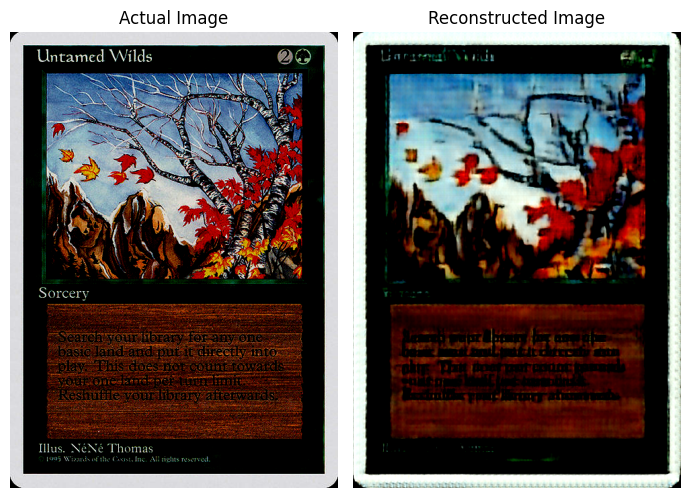

KeyboardInterrupt: 

In [ ]:
model = ResNetAutoencoder()

if LOAD_MODEL:
    model.load_state_dict(torch.load('trained_models/autoencoder.pth'))

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

model.to(device)

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    model.train()
    
    for batch_idx, (features, _) in enumerate(dataloader):
        features = features.to(device)

        optimizer.zero_grad()  # Zero out the gradients at the beginning of the loop
        logits = model(features)  # Forward pass
        loss = loss_fn(logits, features)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

        if batch_idx % LOGGING_INTERVAL == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")
            idx = randint(0, len(dataset))
            img, _ = dataset[idx]
            model.test(img)

        # Save model if required
        if SAVE_MODEL:
            torch.save(model.state_dict(), 'trained_models/autoencoder.pth')

In [ ]:
torch.save(model.state_dict(), 'trained_models/autoencoder.pth')